In [1]:
import utils
import matplotlib
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import glob
import numpy as np
import tensorflow as tf
import operator
from sklearn.preprocessing import LabelEncoder
import time
import ModifiedModels
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Defining the DataSet 

# MasterPath = os.path.abspath("//kuehlapis.mbi.nus.edu.sg/home/jokhun/")
MasterPath = os.path.abspath('//fs9.nus.edu.sg/bie/MBELab/jokhun/Pro 1 - Identification of Diff Cell Types/Adherent cells/')

ImgPaths = glob.glob(os.path.join(MasterPath,"IndiNuc/*_DAPI.tif"))
print('Total Number of ImgPaths = '+str(len(ImgPaths)))
print(ImgPaths[0])

Total Number of ImgPaths = 5843
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\IndiNuc\MAX_HME_Segmented_1974_110.1342_263.22_DAPI.tif


In [3]:
# Getting a slice of the dataset for building the pipeline
# DELETE this section once the pipeline is built
ImgPaths = ImgPaths[0:300]
print('Total Number of ImgPaths = '+str(len(ImgPaths)))
print(ImgPaths[0])

Total Number of ImgPaths = 300
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\IndiNuc\MAX_HME_Segmented_1974_110.1342_263.22_DAPI.tif


In [4]:
# DataPartition

Tr_Paths, Dev_Paths, Ts_Paths = utils.DataPartition(sorted(ImgPaths), Partition=[0.8,0.15,0.05], RanSeed=0)

print ('Length of Training Set = ' + str(len(Tr_Paths)))
print ('1st element of Training Set :\n' + str(Tr_Paths[0]))
print ('Length of Development Set = ' + str(len(Dev_Paths)))
print ('1st element of Development Set :\n' + str(Dev_Paths[0]))
print ('Length of Test Set = ' + str(len(Ts_Paths)))
print ('1st element of Test Set :\n' + str(Ts_Paths[0]))

Length of Training Set = 240
1st element of Training Set :
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\IndiNuc\MAX_HME_Segmented_622_342.8675_664.7455_DAPI.tif
Length of Development Set = 45
1st element of Development Set :
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\IndiNuc\MAX_HME_Segmented_2035_1691.902_132.1049_DAPI.tif
Length of Test Set = 15
1st element of Test Set :
\\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\IndiNuc\MAX_BJ_Segmented_1809_1002.6385_1184.9171_DAPI.tif


Time elapsed during import = 1.7317777080000027 s
Length of Training Set = 240
Length of Development Set = 45
Length of Test Set = 15


(Text(0.5, 1.0, 'Test[0]'), <matplotlib.image.AxesImage at 0x2674c8708d0>)

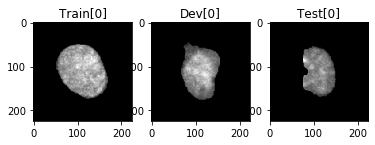

In [5]:
# Import images: Tr_X, Dev_X and Ts_X

ImgScaleFactor = 2
DesiredImgSize = 224

start=time.perf_counter()
with mp.Pool() as pool:
    Tr_X = pool.starmap(utils.ImportImage, [(path,ImgScaleFactor,DesiredImgSize) for path in Tr_Paths])
    Dev_X = pool.starmap(utils.ImportImage, [(path,ImgScaleFactor,DesiredImgSize) for path in Dev_Paths])
    Ts_X = pool.starmap(utils.ImportImage, [(path,ImgScaleFactor,DesiredImgSize) for path in Ts_Paths])
print('Time elapsed during import = '+ str(time.perf_counter() - start) + ' s')

print ('Length of Training Set = '+str(len(Tr_X)))
print ('Length of Development Set = '+str(len(Dev_X)))
print ('Length of Test Set = '+str(len(Ts_X)))

plt.subplot(1,3,1).set_title('Train[0]'), plt.imshow(Tr_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,2).set_title('Dev[0]'), plt.imshow(Dev_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,3).set_title('Test[0]'), plt.imshow(Ts_X[0], cmap='gray', norm=matplotlib.colors.Normalize())

In [6]:
# Import Labels : Tr_Y, Dev_Y and Ts_Y
Tr_Y = [path[path.index('MAX_') + 4 : path.index('_Segmented')] for path in Tr_Paths]
Dev_Y = [path[path.index('MAX_') + 4 : path.index('_Segmented')] for path in Dev_Paths]
Ts_Y = [path[path.index('MAX_') + 4 : path.index('_Segmented')] for path in Ts_Paths]

values, counts = np.unique(Tr_Y, return_counts=True)
print ('Classes in Training Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Dev_Y, return_counts=True)
print ('Classes in Development Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Ts_Y, return_counts=True)
print ('Classes in Test Set : ' + str(values) + ' --- Frequencies : ' + str(counts))

Classes in Training Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [ 88 100  52]
Classes in Development Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [14 20 11]
Classes in Test Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [6 6 3]


In [7]:
# Getting rid of invalid images
counter = 0

Invalid = [i for i,val in enumerate(Tr_X) if type(val)==type(None)]
counter += len(Invalid)
print('Invalid Traininig files = '+str(len(Invalid))+'\n'+str(operator.itemgetter(Invalid)(Tr_Paths)))
Tr_Paths = np.delete(Tr_Paths,Invalid)
for idx in sorted(Invalid, reverse=True):
    del Tr_X[idx]
    del Tr_Y[idx]

Invalid = [i for i,val in enumerate(Dev_X) if type(val)==type(None)]
counter += len(Invalid)
print('Invalid Dev files = '+str(len(Invalid))+'\n'+str(operator.itemgetter(Invalid)(Dev_Paths)))
Dev_Paths = np.delete(Dev_Paths,Invalid)
for idx in sorted(Invalid, reverse=True):
    del Dev_X[idx]
    del Dev_Y[idx]

Invalid = [i for i,val in enumerate(Ts_X) if type(val)==type(None)]
counter += len(Invalid)
print('Invalid Test files = '+str(len(Invalid))+'\n'+str(operator.itemgetter(Invalid)(Ts_Paths)))
Ts_Paths = np.delete(Ts_Paths,Invalid)
for idx in sorted(Invalid, reverse=True):
    del Ts_X[idx]
    del Ts_Y[idx]

print ('\nTotal number of invalid files = '+str(counter))
values, counts = np.unique(Tr_Y, return_counts=True)
print ('Classes in Training Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Dev_Y, return_counts=True)
print ('Classes in Development Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Ts_Y, return_counts=True)
print ('Classes in Test Set : ' + str(values) + ' --- Frequencies : ' + str(counts))

Invalid Traininig files = 3
['\\\\fs9.nus.edu.sg\\bie\\MBELab\\jokhun\\Pro 1 - Identification of Diff Cell Types\\Adherent cells\\IndiNuc\\MAX_HME_Segmented_231_1272.2646_932.8158_DAPI.tif'
 '\\\\fs9.nus.edu.sg\\bie\\MBELab\\jokhun\\Pro 1 - Identification of Diff Cell Types\\Adherent cells\\IndiNuc\\MAX_BJ_Segmented_1327_444.7837_109.4972_DAPI.tif'
 '\\\\fs9.nus.edu.sg\\bie\\MBELab\\jokhun\\Pro 1 - Identification of Diff Cell Types\\Adherent cells\\IndiNuc\\MAX_HME_Segmented_1270_637.0807_64.2024_DAPI.tif']
Invalid Dev files = 0
[]
Invalid Test files = 0
[]

Total number of invalid files = 3
Classes in Training Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [87 98 52]
Classes in Development Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [14 20 11]
Classes in Test Set : ['BJ' 'HME' 'HMF'] --- Frequencies : [6 6 3]


In [8]:
# Restructuring the image dataset and encoding the labels
X_Train = tf.expand_dims(Tr_X, axis=-1)
X_Dev = tf.expand_dims(Dev_X, axis=-1)
X_Test = tf.expand_dims(Ts_X, axis=-1)
print('X_Train shape:'+str(X_Train.shape) + '   X_Dev shape:' + str(X_Dev.shape) + '   X_Test shape:' + str(X_Test.shape))

ResponseEncoder = LabelEncoder()
ResponseEncoder.fit((Tr_Y + Dev_Y + Ts_Y))
NumOfClasses = len(ResponseEncoder.classes_)
print('Number of calsses in the data: '+str(NumOfClasses))
print('Classes in the Data: ' + str(ResponseEncoder.classes_))
Y_Train = ResponseEncoder.transform(Tr_Y)
Y_Dev = ResponseEncoder.transform(Dev_Y)
Y_Test = ResponseEncoder.transform(Ts_Y)
print ('1st element of Tr_Y, Dev_Y and Ts_Y : ' + str(Tr_Y[0]) + ', ' + str(Dev_Y[0]) + ', ' + str(Ts_Y[0]))
print ('1st element of Y_Train, Y_Dev and Y_Test : ' + str(Y_Train[0]) + ', ' + str(Y_Dev[0]) + ', ' + str(Y_Test[0]))

X_Train shape:(237, 224, 224, 1)   X_Dev shape:(45, 224, 224, 1)   X_Test shape:(15, 224, 224, 1)
Number of calsses in the data: 3
Classes in the Data: ['BJ' 'HME' 'HMF']
1st element of Tr_Y, Dev_Y and Ts_Y : HME, HME, BJ
1st element of Y_Train, Y_Dev and Y_Test : 1, 1, 0


In [9]:
# Importing the untrained models

models = {
#     'mod_VGG16' : ModifiedModels.mod_VGG16(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]), 
#     'mod_VGG19' : ModifiedModels.mod_VGG19(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_ResNet50' : ModifiedModels.mod_ResNet50(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_ResNet50V2' : ModifiedModels.mod_ResNet50V2(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_InceptionV3' : ModifiedModels.mod_InceptionV3(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_Xception' : ModifiedModels.mod_Xception(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
#     'mod_InceptionResNetV2' : ModifiedModels.mod_InceptionResNetV2(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
    'mod_NASNetLarge' : ModifiedModels.mod_NASNetLarge(NumOfClasses=NumOfClasses, NumOfInputCh=X_Train.shape[-1], ImgSize=X_Train.shape[1]),
}

ModelKeys=list(models.keys())

print('Initial Test Loss and Accuracy')
InitialEval=[]
for ModelKey in ModelKeys:
    eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
    InitialEval.append(str(ModelKey)+' : '+str(eval))
print ('\n'.join(InitialEval)) 

Initial Test Loss and Accuracy
mod_NASNetLarge : [1.2697465419769287, 0.2]


In [10]:
# Training the models, saving modelcheckpoints and logs

Start=time.perf_counter()
for ModelKey in ModelKeys:
    ModelStart=time.perf_counter()
    print('\nTraining '+str(ModelKey)+'...')
        
    Model_Path = os.path.join(MasterPath,str(ModelKey))
    
    MdlChkpt_Path = os.path.join(Model_Path,"MdlChkpt","MdlChkpt{epoch:02d}-{val_accuracy:.2f}.ckpt")
    MdlChkpt_cb = tf.keras.callbacks.ModelCheckpoint(
        MdlChkpt_Path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, 
        mode='auto', save_freq="epoch"
    )
    TensorBoard_Path = os.path.join(Model_Path,"logs")
    TensorBoard_cb = tf.keras.callbacks.TensorBoard(
        log_dir = TensorBoard_Path, histogram_freq=0, write_graph=False, write_images=False, update_freq="epoch", 
        profile_batch=0, embeddings_freq=0, embeddings_metadata=None
    )
        
    models[ModelKey].fit(
        x=X_Train, y=Y_Train, batch_size=8, epochs=2, initial_epoch=0, verbose=1, callbacks=[MdlChkpt_cb, TensorBoard_cb],
        validation_data=(X_Dev,Y_Dev), shuffle=True
    )
    
    print('\n'+str(ModelKey)+' trained! Training time = '+ str((time.perf_counter()-ModelStart)/60) + ' min!')
    print('Test Loss and Accuracy [Initial] [Final]')
    for i,ModelKey in enumerate(ModelKeys):
        eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
        print(InitialEval[i]+' '+str(eval))
print('\nTotal training time = '+ str((time.perf_counter()-Start)/(60*60)) + ' hr!')


Training mod_NASNetLarge...
Train on 237 samples, validate on 45 samples
Epoch 1/2
237/237 [==============================] - 177s 748ms/sample - loss: 2.0508 - accuracy: 0.4304 - val_loss: 8626.2420 - val_accuracy: 0.4444
Epoch 2/2
237/237 [==============================] - 55s 231ms/sample - loss: 1.3839 - accuracy: 0.4895 - val_loss: 7075.6314 - val_accuracy: 0.4444
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\mod_NASNetLarge\LatestModel\assets

mod_NASNetLarge trained! Training time = 10.160118249300002 min!
Test Loss and Accuracy [Initial] [Final]
mod_NASNetLarge : [1.2697465419769287, 0.2] [7681.88232421875, 0.4]

Total training time = 0.16944240633138885 hr!


In [11]:
# Saving the latest version of each model
for ModelKey in ModelKeys:
    print('\nSaving '+str(ModelKey))
    Save_Path = os.path.join(MasterPath,str(ModelKey),"LatestModel")
    models[ModelKey].save(
        Save_Path, overwrite=False, include_optimizer=True, save_format=None,
        signatures=None, options=None
    )
print('\nThe latest version of each model has been saved!')


Saving mod_NASNetLarge


[WARNING] \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\mod_NASNetLarge\LatestModel already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!
INFO:tensorflow:Assets written to: \\fs9.nus.edu.sg\bie\MBELab\jokhun\Pro 1 - Identification of Diff Cell Types\Adherent cells\mod_NASNetLarge\LatestModel\assets
The latest version of each model has been saved!
